# Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/bank.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [3]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical variables
le = LabelEncoder()
encoded_values = {}  # Dictionary to store mapping of categories to numerical values

data['pdays'] = data['pdays'].replace(['999'], 0)

cat_cols = data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()

for column in cat_cols:
    data[column] = le.fit_transform(data[column])
    encoded_values[column] = dict(zip(le.classes_, le.transform(le.classes_)))


# Print the mapping for each categorical column
for column, mapping in encoded_values.items():
    print(f"{column}: {mapping}")

job: {'admin.': np.int64(0), 'blue-collar': np.int64(1), 'entrepreneur': np.int64(2), 'housemaid': np.int64(3), 'management': np.int64(4), 'retired': np.int64(5), 'self-employed': np.int64(6), 'services': np.int64(7), 'student': np.int64(8), 'technician': np.int64(9), 'unemployed': np.int64(10), 'unknown': np.int64(11)}
marital: {'divorced': np.int64(0), 'married': np.int64(1), 'single': np.int64(2), 'unknown': np.int64(3)}
education: {'basic.4y': np.int64(0), 'basic.6y': np.int64(1), 'basic.9y': np.int64(2), 'high.school': np.int64(3), 'illiterate': np.int64(4), 'professional.course': np.int64(5), 'university.degree': np.int64(6), 'unknown': np.int64(7)}
default: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
housing: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
loan: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
contact: {'cellular': np.int64(0), 'telephone': np.int64(1)}
month: {'apr': np.int64(0), 'aug': np.int64(1), 'dec': np.i

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (X) and target (y)
X = data.drop(columns=['y'])  
y = data['y']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [5]:
# Calculate correlations with the target variable ('Income')
correlations = data.corr()['y'].sort_values(ascending=False)

# Print correlations
print(correlations)

y                 1.000000
duration          0.405274
previous          0.230181
poutcome          0.129789
education         0.057799
cons.conf.idx     0.054878
marital           0.046203
age               0.030399
job               0.025122
day_of_week       0.015967
housing           0.011552
loan             -0.004909
month            -0.006065
campaign         -0.066357
default          -0.099352
cons.price.idx   -0.136211
contact          -0.144773
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354536
Name: y, dtype: float64


In [20]:
columns_to_drop = ['education', 'cons.conf.idx', 'marital', 'age', 'job', 'day_of_week', 'month', 'campaign', 'default']
data_filtered = data.drop(columns=columns_to_drop)

In [21]:
# Save the preprocessed data
data_filtered.to_csv("../data/filtered.csv", index=False)

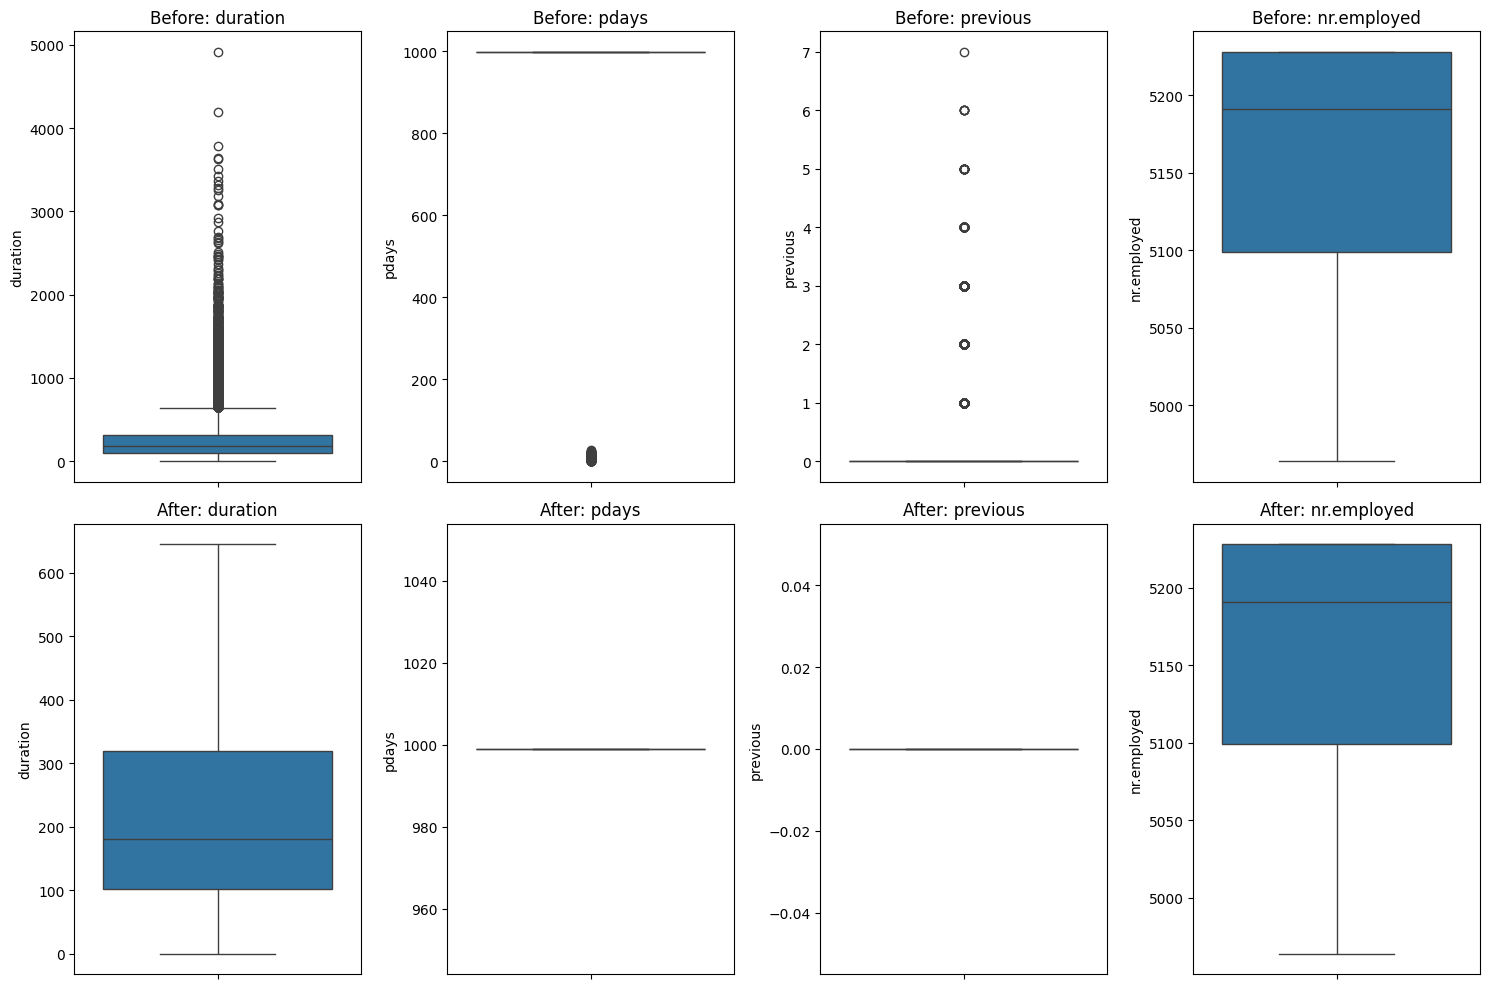

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


# Define a function to handle outliers
def handle_outliers_iqr(column):
    # Calculate quartiles
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count occurrences of outliers
    outliers = (column < lower_bound) | (column > upper_bound)
    outlier_count = outliers.sum()

    # If the outlier count is less than 200, just return them as is
    if outlier_count < 200:
        return column
    else:
        # Round outliers to the upper or lower bound
        return column.apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    
num_cols = ['duration', 'pdays', 'previous', 'nr.employed']
# Apply outlier handling for each numerical column
for column in num_cols:
    data_filtered[column] = handle_outliers_iqr(data_filtered[column])

# Create subplots for the box plots before and after outlier handling
fig, axes = plt.subplots(nrows=2, ncols=len(num_cols), figsize=(15, 10))

# Plot box plots before outlier handling
for i, column in enumerate(num_cols):
    sns.boxplot(y=data[column], ax=axes[0, i])
    axes[0, i].set_title(f'Before: {column}')

# Plot box plots after outlier handling
for i, column in enumerate(num_cols):
    sns.boxplot(y=data_filtered[column], ax=axes[1, i])
    axes[1, i].set_title(f'After: {column}')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [25]:
# Save the modified data into another CSV file
output_file_path = "../data/new_data.csv"
data_filtered.to_csv(output_file_path, index=False)

In [26]:
import pandas as pd

# Load the cleaned and transformed dataset
data_filtered = pd.read_csv('../data/new_data.csv')

# Count the occurrences of each class in the target variable
class_counts = data_filtered['y'].value_counts()

# Print the class counts
print("Class Counts:")
print(class_counts)

# Calculate the class distribution as percentages
class_distribution = class_counts / class_counts.sum() * 100

# Print the class distribution
print("\nClass Distribution (%):")
print(class_distribution)

Class Counts:
y
0    36548
1     4640
Name: count, dtype: int64

Class Distribution (%):
y
0    88.734583
1    11.265417
Name: count, dtype: float64


In [27]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [28]:
import pandas as pd

y_resampled_series = pd.Series(y_resampled)

# Print class counts
class_counts = y_resampled_series.value_counts()
print("Class Counts:")
print(class_counts)

# Print class distribution (%)
class_distribution = y_resampled_series.value_counts(normalize=True) * 100
print("\nClass Distribution (%):")
print(class_distribution)

Class Counts:
y
0    36548
1    36548
Name: count, dtype: int64

Class Distribution (%):
y
0    50.0
1    50.0
Name: proportion, dtype: float64


In [29]:
import pandas as pd

# Assuming you have X_resampled and y_resampled after applying SMOTE

# Combine X_resampled and y_resampled into a single DataFrame
resampled_data = pd.DataFrame(X_resampled, columns=X.columns)  # Assuming X has column names
resampled_data['y'] = y_resampled  # y is the target column name

# Save the resampled data to a CSV file
resampled_data.to_csv('../data/resampled_data.csv', index=False)

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from 

# Load the cleaned and transformed dataset
new_data = pd.read_csv('../data/resampled_data.csv')

# Define features (X) and target (y)
X = new_data.drop(columns=['y']) 
y = new_data['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

# Evaluate Random Forest Classifier
print("\nRandom Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:")
print(classification_report(y_test, rf_predictions))



Random Forest Classifier:
Accuracy: 0.9526675786593707
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7332
           1       0.94      0.97      0.95      7288

    accuracy                           0.95     14620
   macro avg       0.95      0.95      0.95     14620
weighted avg       0.95      0.95      0.95     14620




Confusion Matrix for Random Forest Classifier:


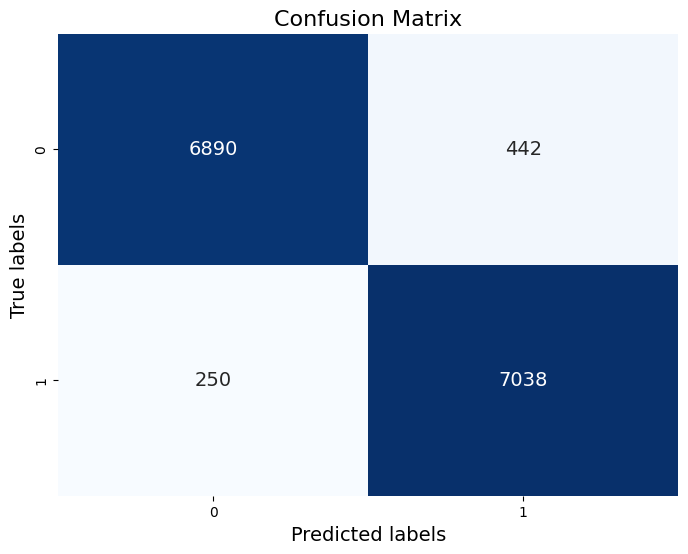

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print Confusion Matrix for Random Forest Classifier
print("\nConfusion Matrix for Random Forest Classifier:")
cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, random_state=31, test_size=0.2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)), # Input layer + first hidden layer
    Dropout(0.3), # To prevent overfitting
    Dense(64, activation='relu'), # Second hidden layer
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Output layer - Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

# Evaluate the model based on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

# Generate classification report
from sklearn.metrics import classification_report

# Predict on validation data
y_predict = (model.predict(X_val)>0.5).astype("int32")
print(classification_report(y_val, y_predict))

Epoch 1/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5885 - loss: 27.4313 - val_accuracy: 0.7118 - val_loss: 0.6126
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6661 - loss: 0.6361 - val_accuracy: 0.7734 - val_loss: 0.5146
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7297 - loss: 0.5653 - val_accuracy: 0.7832 - val_loss: 0.4752
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7557 - loss: 0.5139 - val_accuracy: 0.8085 - val_loss: 0.4141
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7972 - loss: 0.4655 - val_accuracy: 0.8185 - val_loss: 0.3943
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8128 - loss: 0.4528 - val_accuracy: 0.7797 - val_loss: 0.4263
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8278 - loss: 0.4241 - val_accuracy: 0.8581 - val_loss: 0.3634
Epoch 8/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8339 - loss: 0.3995 -

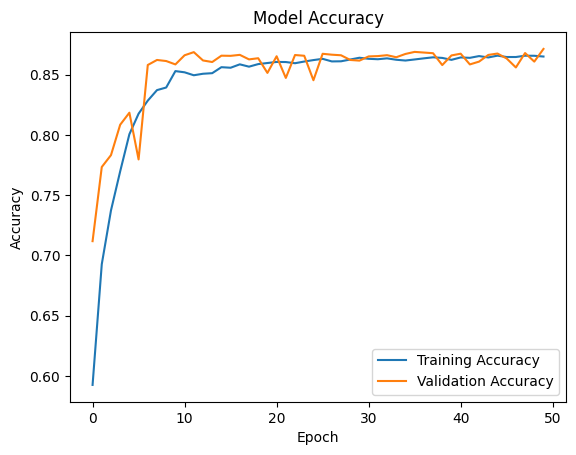

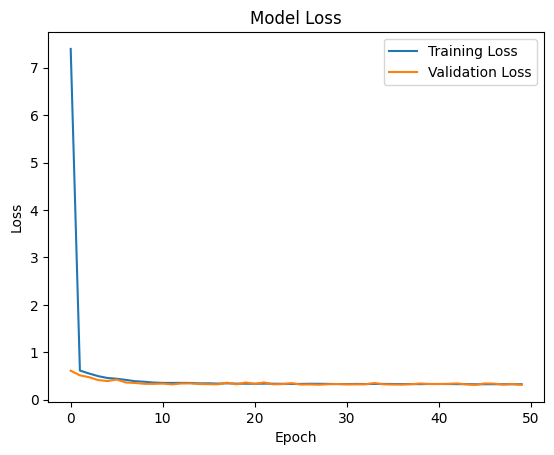

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [32]:
from keras_tuner import HyperModel

# Define the hypermodel class
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # Input layer - 1st hidden layer
        model.add(Dense(units=hp.Int('units_input', min_value=64, max_value=256, step=32),
                        activation='relu', input_shape=(X_train.shape[1],)))
        
        # Add a dropout layer
        model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))

        # Second hidden layer
        model.add(Dense(units=hp.Int('units_hidden', min_value=32, max_value=128, step=32),
                        activation='relu'))
        
        # Add a dropout layer
        model.add(Dropout(rate=hp.Float('dropout_hidden', min_value=0.1, max_value=0.5, step=0.1)))

        # Add the output layer
        model.add(Dense(1, activation='sigmoid')) # Binary classification

        # Compile the model
        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )
        return model
    

In [33]:
from keras_tuner.tuners import RandomSearch

# Initialize the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuning_dir',
    project_name='bank_ann'
)

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=20,
             batch_size=32)

# Show a summary of the search
tuner.results_summary()

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best number of units for the input layer is {best_hps.get('units_input')},
Dropout rate for input layer is {best_hps.get('dropout_input')},
Hidden layer units are {best_hps.get('units_hidden')},
Dropout rate for hidden layer is {best_hps.get('dropout_hidden')},
and the optimizer is {best_hps.get('optimizer')}.
""")



Trial 10 Complete [00h 02m 12s]
val_accuracy: 0.8648426830768585

Best val_accuracy So Far: 0.8721614181995392
Total elapsed time: 00h 25m 00s
Results summary
Results in my_tuning_dir\bank_ann
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
units_input: 128
dropout_input: 0.1
units_hidden: 96
dropout_hidden: 0.4
optimizer: adam
Score: 0.8721614181995392

Trial 04 summary
Hyperparameters:
units_input: 64
dropout_input: 0.4
units_hidden: 32
dropout_hidden: 0.1
optimizer: rmsprop
Score: 0.8713748157024384

Trial 02 summary
Hyperparameters:
units_input: 224
dropout_input: 0.1
units_hidden: 128
dropout_hidden: 0.5
optimizer: adam
Score: 0.8692202270030975

Trial 05 summary
Hyperparameters:
units_input: 128
dropout_input: 0.4
units_hidden: 96
dropout_hidden: 0.30000000000000004
optimizer: rmsprop
Score: 0.8683652579784393

Trial 01 summary
Hyperparameters:
units_input: 192
dropout_input: 0.4
units_hidden: 32
dropout_hidden: 0.30000000

NameError: name 'early_stop' is not defined

In [34]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=32,
                        verbose=1)

# Save the best model
best_model.save('best_neural_network_model.h5')

# Predict on validation data
y_pred = (best_model.predict(X_val) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_val, y_pred))

Epoch 1/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6188 - loss: 13.7522 - val_accuracy: 0.7427 - val_loss: 0.5425
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7082 - loss: 0.5701 - val_accuracy: 0.7419 - val_loss: 0.5055
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7256 - loss: 0.5408 - val_accuracy: 0.7880 - val_loss: 0.4712
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7402 - loss: 0.5157 - val_accuracy: 0.8182 - val_loss: 0.3935
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7853 - loss: 0.4752 - val_accuracy: 0.8371 - val_loss: 0.3773
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8079 - loss: 0.4520 - val_accuracy: 0.8624 - val_loss: 0.3514
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8154 - loss: 0.4405 - val_accuracy: 0.8231 - val_loss: 0.3715
Epoch 8/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8238 - loss: 0.4307 -

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      7294
           1       0.86      0.89      0.88      7326

    accuracy                           0.87     14620
   macro avg       0.87      0.87      0.87     14620
weighted avg       0.87      0.87      0.87     14620

